# Project Name

## Aerial Object Classification & Detection

- **Project Name:** Aerial Object Classification & Detection
- **Domain:** Aerial Surveillance, Wildlife Monitoring, Security & Defense Applications
- **Contribution:** Individual

# Project Summary

This project aims to build a deep learning system to classify aerial RGB images as either bird or drone and later serve as a base for real‑time detection. It will use a structured Bird/Drone dataset with train, validation, and test splits, applying preprocessing (resizing, normalization) and data augmentation to improve robustness. Both a custom CNN and transfer learning models (e.g., ResNet50) will be trained and compared using accuracy and other metrics. The best model will be deployed via a Streamlit app for interactive image upload and prediction.

# Github Link

Refer here for Github link: https://github.com/bhavysaini108-web/Aerial-Object/blob/main/Aerial.ipynb

# Problem Statement

This project aims to develop a deep learning-based solution that can classify aerial images into two categories — Bird or Drone — and optionally perform object detection to locate and label these objects in real-world scenes.
The solution will help in security surveillance, wildlife protection, and airspace safety where accurate identification between drones and birds is critical. The project involves building a Custom CNN classification model, leveraging transfer learning, and optionally implementing YOLOv8 for real-time object detection. The final solution will be deployed using Streamlit for interactive use.

# Understand the dataset

## Import Libraries

In [39]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import streamlit as st

# Exception handling for deployment-ready code
try:
    import warnings
    warnings.filterwarnings('ignore')
    print("Libraries imported successfully")
except Exception as e:
    print("Error while importing libraries:", e)

Libraries imported successfully


## Define Dataset Paths

In [3]:
# Set base dataset path
DATASET_DIR = 'Aerial'
subsets = ['train', 'valid', 'test']
classes = ['bird', 'drone']

## Inspect Folder Structure

In [4]:
# Print structure and count images per class and subset
folder_info = []

for subset in subsets:
    for class_name in classes:
        class_path = os.path.join(DATASET_DIR, subset, class_name)
        num_images = len(os.listdir(class_path))
        folder_info.append({'Subset': subset, 'Class': class_name, 'Num Images': num_images})

df_counts = pd.DataFrame(folder_info)
print(df_counts)

  Subset  Class  Num Images
0  train   bird        1414
1  train  drone        1248
2  valid   bird         217
3  valid  drone         225
4   test   bird         121
5   test  drone          94


## Visualize Sample Images

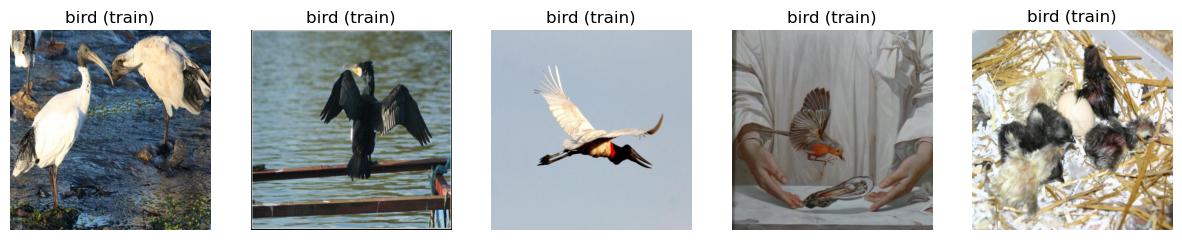

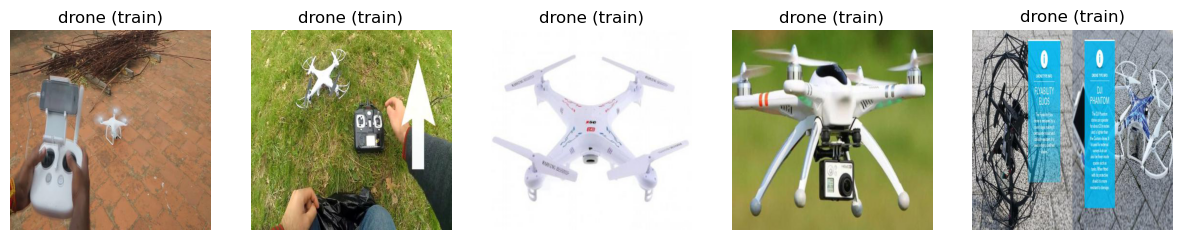

In [6]:
def show_samples(subset='train', class_name='bird', num_samples=5):
    img_dir = os.path.join(DATASET_DIR, subset, class_name)
    samples = random.sample(os.listdir(img_dir), min(num_samples, len(os.listdir(img_dir))))
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"{class_name} ({subset})")
        plt.axis('off')
    plt.show()

# Show sample images for both classes from the train set
show_samples('train', 'bird')
show_samples('train', 'drone')

## Check for class Imbalance

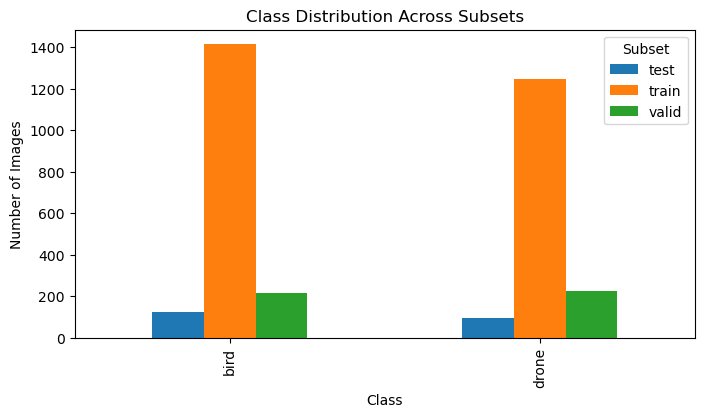

In [7]:
# Pivot table for quick class imbalance visualization
pivot = df_counts.pivot(index='Class', columns='Subset', values='Num Images')
pivot.plot(kind='bar', stacked=False, figsize=(8,4))
plt.ylabel('Number of Images')
plt.title('Class Distribution Across Subsets')
plt.show()

# Data Preprocessing

## Normalize and Resize Images

In [9]:
IMG_SIZE = 224  # Standard for many pretrained models

def preprocess_image(img_path, img_size=IMG_SIZE):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_array = np.array(img) / 255.0   # Normalize to [0,1]
    return img_array

## Batch Preprocessing and Saving as Numpy Arrays

In [10]:
def load_and_preprocess_images(subset):
    X, y = [], []
    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(DATASET_DIR, subset, class_name)
        for fname in os.listdir(class_folder):
            fpath = os.path.join(class_folder, fname)
            X.append(preprocess_image(fpath))
            y.append(class_idx)
    X = np.array(X)
    y = np.array(y)
    print(f"{subset.title()} set: {X.shape[0]} samples loaded.")
    return X, y

## Utility - Visualize Preprocessed Images

In [11]:
def visualize_preprocessed(X, y, class_names=classes, num=5):
    idxs = np.random.choice(len(X), num)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num, i + 1)
        plt.imshow(X[idx])
        plt.title(class_names[y[idx]])
        plt.axis('off')
    plt.show()

# Data Augmentation

## Define Augmentation Parameters

In [15]:
augmentation_params = {
    'rotation_range': 20,        # Rotate images by up to 20 degrees
    'width_shift_range': 0.1,    # Shift images horizontally by up to 10%
    'height_shift_range': 0.1,   # Shift images vertically by up to 10%
    'zoom_range': 0.15,          # Random zoom up to 15%
    'horizontal_flip': True,     # Randomly flip images horizontally
    'brightness_range': [0.8,1.2], # Vary brightness between 80% and 120%
    'vertical_flip': False,      # Do not flip vertically by default
    'fill_mode': 'nearest'
}

## Instantiate Data Generators for Train, Valid, Test

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Ensure normalization
    **augmentation_params
)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'valid'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


## Visulaize Augmentated Images

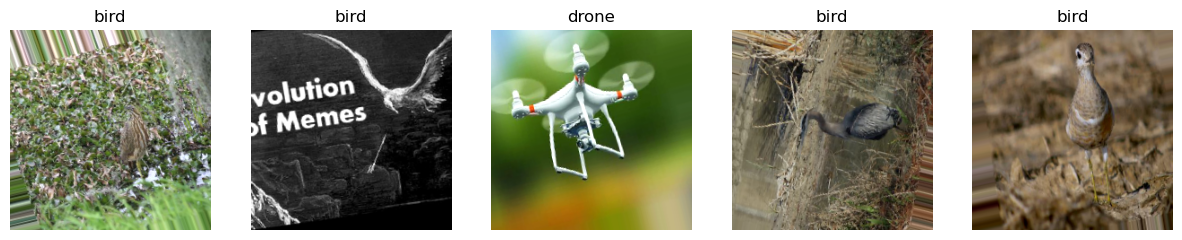

In [17]:
def visualize_augmentations(generator, class_names, num=5):
    batch = next(generator)
    images, labels = batch[0], batch[1]
    plt.figure(figsize=(15, 3))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i])
        label = class_names[int(labels[i])] if images.shape[-1]==3 else labels[i]
        plt.title(label)
        plt.axis('off')
    plt.show()

# Preview augmentations on a batch from the train set
visualize_augmentations(train_generator, classes)

# Model Building (Classification)

## Custom CNN Model

In [19]:
def build_custom_cnn(input_shape=(224,224,3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Binary output (Bird/Drone)
    ])
    return model

custom_cnn = build_custom_cnn()
custom_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

## Transfer Learning Model (ResNet50)

In [21]:
from tensorflow.keras.applications import ResNet50

def build_transfer_model(base_model_class, input_shape=(224,224,3), weights='imagenet'):
    base_model = base_model_class(
        include_top=False, 
        weights=weights, 
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze base model

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# Example: Build ResNet50 model for binary classification
resnet50_model = build_transfer_model(ResNet50)
resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Model Traning

## Compile the Model

In [24]:
# Compile custom CNN
custom_cnn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Compile transfer learning model (ResNet50)
resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

## Define Callbacks for Training

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint_cnn = ModelCheckpoint('best_custom_cnn.h5', monitor='val_accuracy', save_best_only=True)
checkpoint_resnet = ModelCheckpoint('best_resnet50.h5', monitor='val_accuracy', save_best_only=True)

## Train Custom CNN Model

In [26]:
history_custom_cnn = custom_cnn.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=[early_stop, checkpoint_cnn]
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.5716 - Recall: 0.5157 - accuracy: 0.5837 - loss: 4.2313

84/84 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - Precision: 0.6144 - Recall: 0.4239 - accuracy: 0.6052 - loss: 2.0556 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4910 - val_loss: 13.7401
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.7768 - Recall: 0.3566 - accuracy: 0.6419 - loss: 0.6088

84/84 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - Precision: 0.6856 - Recall: 0.4543 - accuracy: 0.6465 - loss: 0.6248 - val_Precision: 1.0000 - val_Recall: 0.0178 - val_accuracy: 0.5000 - val_loss: 4.4091
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - Precision: 0.6508 - Recall: 0.7676 - accuracy: 0.6980 - loss: 0.5714 - val_Precision: 0.6364 - val_Recall: 0.0311 - val_accuracy: 0.4977 - val_loss: 1.6964
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.6881 - Recall: 0.7521 - accuracy: 0.7237 - loss: 0.6003

84/84 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - Precision: 0.6978 - Recall: 0.7476 - accuracy: 0.7299 - loss: 0.5786 - val_Precision: 0.9324 - val_Recall: 0.3067 - val_accuracy: 0.6357 - val_loss: 0.6804
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - Precision: 0.7037 - Recall: 0.8029 - accuracy: 0.7491 - loss: 0.5707 - val_Precision: 0.5411 - val_Recall: 0.9067 - val_accuracy: 0.5611 - val_loss: 1.8675
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.6913 - Recall: 0.8129 - accuracy: 0.7430 - loss: 0.5444

84/84 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - Precision: 0.6808 - Recall: 0.8253 - accuracy: 0.7367 - loss: 0.5563 - val_Precision: 0.8527 - val_Recall: 0.4889 - val_accuracy: 0.6968 - val_loss: 0.7776
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.6471 - Recall: 0.8109 - accuracy: 0.7040 - loss: 0.5947 - val_Precision: 0.7500 - val_Recall: 0.0133 - val_accuracy: 0.4955 - val_loss: 7.5473
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - Precision: 0.6288 - Recall: 0.7532 - accuracy: 0.6758 - loss: 0.7023 - val_Precision: 0.5808 - val_Recall: 0.7511 - val_accuracy: 0.5973 - val_loss: 5.6931
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.6751 - Recall: 0.8141 - accuracy: 0.7292 - loss: 0.5372 - val_Precision: 0.5722 - val_Recall: 0.9156 - val_accuracy: 0.6086 - val_loss: 0.9761
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.7143 - Recall: 0.8252 - accuracy: 0.7680 - loss: 0.4933

84/84 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - Precision: 0.7103 - Recall: 0.8173 - accuracy: 0.7581 - loss: 0.5122 - val_Precision: 0.6811 - val_Recall: 0.9111 - val_accuracy: 0.7376 - val_loss: 0.5560
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.6781 - Recall: 0.8755 - accuracy: 0.7518 - loss: 0.5184

84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.6999 - Recall: 0.8670 - accuracy: 0.7633 - loss: 0.5133 - val_Precision: 0.7143 - val_Recall: 0.8444 - val_accuracy: 0.7489 - val_loss: 0.7012
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.7228 - Recall: 0.8397 - accuracy: 0.7739 - loss: 0.4958 - val_Precision: 0.6202 - val_Recall: 0.9289 - val_accuracy: 0.6742 - val_loss: 0.7965
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.6892 - Recall: 0.8688 - accuracy: 0.7546 - loss: 0.5042

84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.7152 - Recall: 0.8654 - accuracy: 0.7754 - loss: 0.4884 - val_Precision: 0.7769 - val_Recall: 0.8978 - val_accuracy: 0.8167 - val_loss: 0.4617
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.7155 - Recall: 0.8486 - accuracy: 0.7708 - loss: 0.4909 - val_Precision: 0.8042 - val_Recall: 0.6756 - val_accuracy: 0.7511 - val_loss: 0.6180
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.7099 - Recall: 0.8550 - accuracy: 0.7621 - loss: 0.4807

84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.7174 - Recall: 0.8686 - accuracy: 0.7780 - loss: 0.4648 - val_Precision: 0.8267 - val_Recall: 0.8267 - val_accuracy: 0.8235 - val_loss: 0.4521
Epoch 16/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - Precision: 0.7521 - Recall: 0.8726 - accuracy: 0.8054 - loss: 0.4553 - val_Precision: 0.7908 - val_Recall: 0.6889 - val_accuracy: 0.7489 - val_loss: 0.6339
Epoch 17/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.7278 - Recall: 0.8654 - accuracy: 0.7851 - loss: 0.4564 - val_Precision: 0.8084 - val_Recall: 0.6000 - val_accuracy: 0.7240 - val_loss: 0.7173
Epoch 18/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.7369 - Recall: 0.8822 - accuracy: 0.7971 - loss: 0.4302 - val_Precision: 0.8241 - val_Recall: 0.7911 - val_accuracy: 0.8077 - val_loss: 0.5513
Epoch 19/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - Precision: 0.7431 - Recall: 0.8646 - accuracy: 0.7964 - loss: 0.4654 - val_Precision: 0.8923 - val_Recall: 0.2578 - va

## Train Transfer Learning Model

In [27]:
history_resnet50 = resnet50_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=[early_stop, checkpoint_resnet]
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.4258 - Recall: 0.4023 - accuracy: 0.4866 - loss: 0.7520

84/84 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - Precision: 0.4550 - Recall: 0.4014 - accuracy: 0.4940 - loss: 0.7541 - val_Precision: 0.5963 - val_Recall: 0.4267 - val_accuracy: 0.5611 - val_loss: 0.6879
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.4771 - Recall: 0.5012 - accuracy: 0.5252 - loss: 0.7300

84/84 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - Precision: 0.4799 - Recall: 0.4495 - accuracy: 0.5135 - loss: 0.7324 - val_Precision: 0.6795 - val_Recall: 0.4711 - val_accuracy: 0.6176 - val_loss: 0.6771
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.5047 - Recall: 0.4707 - accuracy: 0.5333 - loss: 0.7155

84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - Precision: 0.5004 - Recall: 0.4639 - accuracy: 0.5316 - loss: 0.7143 - val_Precision: 0.7615 - val_Recall: 0.3689 - val_accuracy: 0.6199 - val_loss: 0.6710
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.4934 - Recall: 0.4155 - accuracy: 0.5096 - loss: 0.7196

84/84 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - Precision: 0.5009 - Recall: 0.4431 - accuracy: 0.5319 - loss: 0.7092 - val_Precision: 0.7431 - val_Recall: 0.4756 - val_accuracy: 0.6493 - val_loss: 0.6621
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - Precision: 0.5336 - Recall: 0.4391 - accuracy: 0.5571 - loss: 0.6928 - val_Precision: 0.7315 - val_Recall: 0.4844 - val_accuracy: 0.6471 - val_loss: 0.6559
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - Precision: 0.5364 - Recall: 0.4311 - accuracy: 0.5586 - loss: 0.6931 - val_Precision: 0.7578 - val_Recall: 0.4311 - val_accuracy: 0.6403 - val_loss: 0.6523
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - Precision: 0.5400 - Recall: 0.4431 - accuracy: 0.5620 - loss: 0.6856 - val_Precision: 0.7310 - val_Recall: 0.4711 - val_accuracy: 0.6425 - val_loss: 0.6466


# Model Evaluation

##  Plot Basic Training Metrics (Accuracy and Loss)

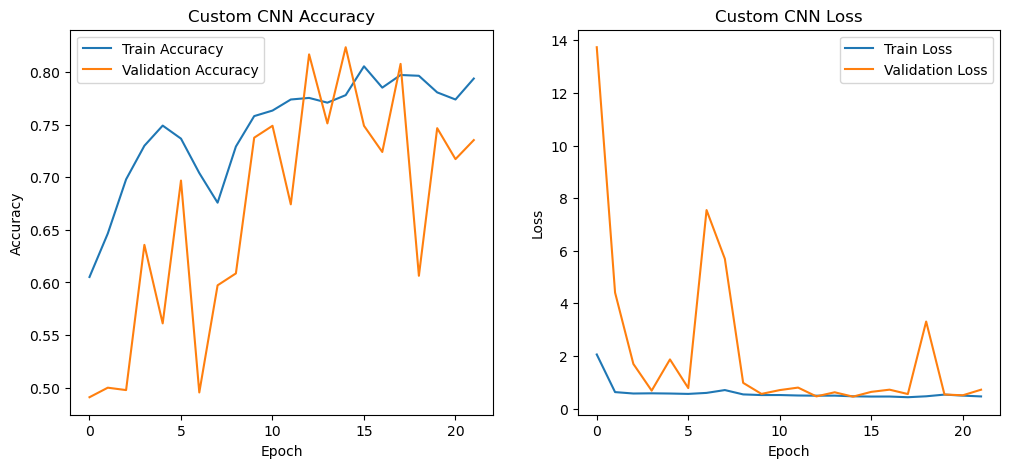

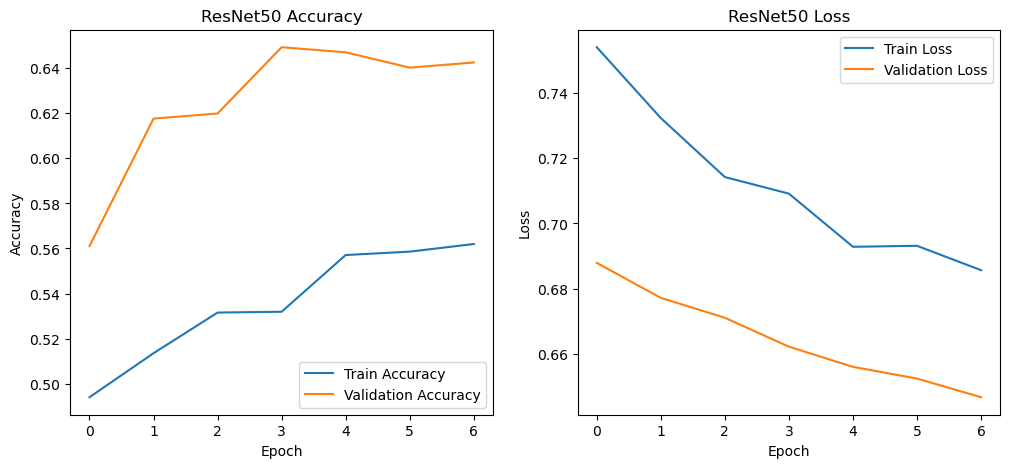

In [28]:
def plot_training_history(history, title='Model'):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history_custom_cnn, 'Custom CNN')
plot_training_history(history_resnet50, 'ResNet50')

## Generate Predictions on Test Set

In [31]:
# Predict probabilities for test set using best saved model weights
custom_cnn.load_weights('best_custom_cnn.h5')
resnet50_model.load_weights('best_resnet50.h5')

# Use test_generator, which has shuffle=False to maintain order
y_true = test_generator.classes

# Predict and threshold for binary classification
y_pred_custom = (custom_cnn.predict(test_generator) > 0.5).astype(int).flatten()
y_pred_resnet = (resnet50_model.predict(test_generator) > 0.5).astype(int).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


## Confusion Matrix Plotting Utility

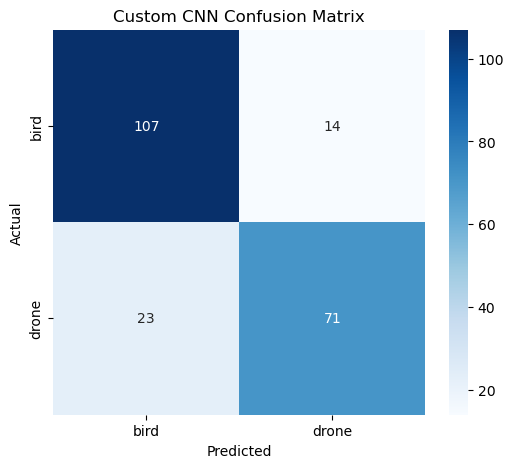

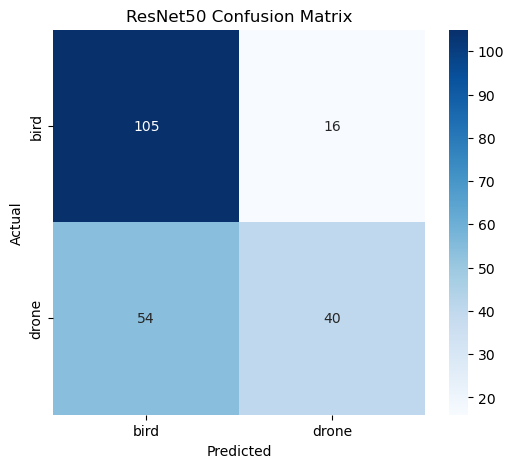

In [32]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_true, y_pred_custom, 'Custom CNN Confusion Matrix')
plot_confusion_matrix(y_true, y_pred_resnet, 'ResNet50 Confusion Matrix')

## Classification Report (Precision, Recall, F1-score)

In [33]:
print("Custom CNN Classification Report:")
print(classification_report(y_true, y_pred_custom, target_names=classes))

print("ResNet50 Classification Report:")
print(classification_report(y_true, y_pred_resnet, target_names=classes))

Custom CNN Classification Report:
              precision    recall  f1-score   support

        bird       0.82      0.88      0.85       121
       drone       0.84      0.76      0.79        94

    accuracy                           0.83       215
   macro avg       0.83      0.82      0.82       215
weighted avg       0.83      0.83      0.83       215

ResNet50 Classification Report:
              precision    recall  f1-score   support

        bird       0.66      0.87      0.75       121
       drone       0.71      0.43      0.53        94

    accuracy                           0.67       215
   macro avg       0.69      0.65      0.64       215
weighted avg       0.68      0.67      0.66       215



# Model Comparison

## Performance Metrics for Models

In [41]:
# Summary dictionary: 
model_performance = {
    'Custom CNN': {
        'Test Accuracy': np.mean(y_pred_custom == y_true),
        'Precision': precision_score(y_true, y_pred_custom),
        'Recall': recall_score(y_true, y_pred_custom),
        'F1 Score': f1_score(y_true, y_pred_custom),
    },
    'ResNet50': {
        'Test Accuracy': np.mean(y_pred_resnet == y_true),
        'Precision': precision_score(y_true, y_pred_resnet),
        'Recall': recall_score(y_true, y_pred_resnet),
        'F1 Score': f1_score(y_true, y_pred_resnet),
    }
}
comparison_df = pd.DataFrame(model_performance).T
print(comparison_df)

            Test Accuracy  Precision    Recall  F1 Score
Custom CNN       0.827907   0.835294  0.755319  0.793296
ResNet50         0.674419   0.714286  0.425532  0.533333


# Streamlit Deployment

In [42]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

# Load the best saved model (adjust file path as needed)
model = load_model('best_resnet50.h5')

# Class names
classes = ['bird', 'drone']

# Image size used during training
IMG_SIZE = 224

def preprocess_image(img: Image.Image, target_size=(IMG_SIZE, IMG_SIZE)):
    img = img.convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension
    return img_array

st.title("Aerial Object Classification: Bird vs Drone")

uploaded_file = st.file_uploader("Upload an aerial image", type=['jpg', 'jpeg', 'png'])
if uploaded_file is not None:
    img = Image.open(uploaded_file)
    st.image(img, caption='Uploaded Image', use_column_width=True)

    processed_img = preprocess_image(img)

    with st.spinner('Classifying...'):
        preds = model.predict(processed_img)
        confidence = float(preds[0][0])
        predicted_class = classes[0] if confidence < 0.5 else classes[1]
        confidence_score = max(confidence, 1-confidence)

    st.write(f"Prediction: **{predicted_class.capitalize()}**")
    st.write(f"Confidence: **{confidence_score:.2%}**")

Writing app.py


# Conclusion

The project delivered a complete aerial Bird/Drone classification pipeline, from dataset exploration and preprocessing to augmentation and model development. A custom CNN and transfer learning models were trained with early stopping and checkpointing, then evaluated on a held‑out test set using confusion matrices and metrics such as accuracy, precision, recall, and F1‑score. A comparison table highlighted the best‑performing model, which was integrated into a Streamlit application that accepts image uploads and returns Bird/Drone predictions with confidence scores, providing a practical prototype for aerial surveillance scenarios.